# Generating a fake mini-wikipedia

In [ ]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time


from sif.sif_src import *
from sif.greedy_sim_max import *

from gpt2.interactive_conditional_samples import interact_model

from gran.granmodel import *
import gran.gran_sampler as gs

## Generating the link network with GRAN

#### GRAN setup

In [2]:
mdir = 'gran/config'
mname = 'model_small.pth'
cname = 'config_small.yaml'

#### Generate the link network with GRAN

In [3]:
#t = time.time()
G = gs.graph_sample(mdir, mname, cname, num_gen=1)[0]
#print('Graph generation time: ' + str(round(time.time() - t, 4)) + ' secs')

#### Get some basic stats from the generated link network and visualise it

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 36
Average degree:   5.5385


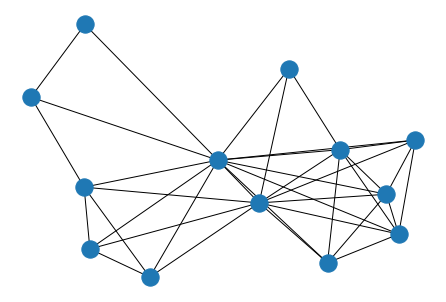

In [4]:
print(nx.info(G))
_ = nx.draw(G)

## Generate the fake articles with GPT-2

Generated articles are discarded if they don't contain the **<|endoftext|>** token, or they are less than 50 words long.

In [5]:
t = time.time()
articles = interact_model(
                   model_path='gpt2/models',
                   model_name='smallWikiPages',
                   raw_text='== Article Start ==\n',
                   nsamples=len(G),
                   batch_size=1,
                   temperature=0.85,
                   top_k=0,
                   top_p=0.0
                  )
print('Article generation time: ' + str(round((time.time() - t)/60, 2)) + ' mins')

Article generation time: 3.27 mins


#### Get lists of the generated article titles and intro sections. Print article titles.

In [6]:
articleTitles = [i[:i.find('\n')] for i in articles]
intros = [i[:i.find('==')-3] for i in articles]
articleTitles

['Gerry Alexander (VC)',
 'Attack on Baden-Württemberg',
 'Kissinger, Thomas',
 'North Carolina Forces Civilian E-School',
 'Marine Mammal Research Laboratory (United States Marine Mammal Research Laboratory)',
 'HMCS Wellington',
 'Ron McKees',
 'RETACS (dog)',
 'List of Royal Air Force base of operations and installations',
 'Navy Cross for Civilian Appointments',
 'William Shipley',
 'Mary Patterson (artist)',
 'The Battle of Eden (1864)']

## SIF embedding of article intro sections

#### SIF embedding setup

In [8]:
wordfile = 'sif/paragram_sl999_small.txt'
weightfile = 'sif/enwiki_vocab_min200.txt'
weightpara = 1e-3 

t = time.time()
word_dict, word_embeddings = getWordmap(wordfile)
updated_weightfile_weights = getWordWeight(weightfile, weightpara) 
word_weights = getWeight(word_dict, updated_weightfile_weights) 
print('SIF setup time: ' + str(round(time.time() - t, 4)) + ' secs')

SIF setup time: 4.2053 secs


#### Run SIF embedding and get all article intro section cosine similarities

In [9]:
t = time.time()
sims_matrix = allSIFSimilarities(intros, word_dict, word_embeddings, word_weights, 1)
print('Similarity calculation time: ' + str(round(time.time() - t, 4)) + ' secs')
print('Top-left 5x5 of similarity matrix:\n' + str(sims_matrix[np.ix_(range(5), range(5))]))

Similarity calculation time: 0.035 secs
Top-left 5x5 of similarity matrix:
[[ 1.          0.19407849  0.19852883 -0.12397149 -0.15173248]
 [ 0.19407849  1.          0.13437906  0.16113226  0.01392884]
 [ 0.19852883  0.13437906  1.         -0.04794637 -0.16770663]
 [-0.12397149  0.16113226 -0.04794637  1.          0.16287223]
 [-0.15173248  0.01392884 -0.16770663  0.16287223  1.        ]]


## Get node:article assignment which maximises total article similarity

This can be written as a case of the *Quadratic Assignment Problem* which is NP-hard. I've used a greedy heuristic algorithm to find a good, although not necessarily globally optimal, assignment.

The greedy algorithm is run `nrounds` times with different initial configurations and takes the run which produced the highest score.

In [11]:
t = time.time()
nodeAssignment = greedySimilarityMax(G, sims_matrix, nrounds = 100)
print('Similarity calculation time: ' + str(round(time.time() - t, 4)) + ' secs')
print('Best node assignment found:')
print(nodeAssignment)

Best S = 8.915356367384046
Similarity calculation time: 2.3168 secs
Best node assignment found:
{0: 12, 1: 7, 2: 4, 3: 9, 4: 3, 5: 1, 6: 5, 7: 8, 8: 2, 9: 0, 10: 6, 11: 10, 12: 11}


#### Relabel edges with their similarity under this assignment

In [12]:
for i in range(len(G)):
    for j in range(i):
        # Try relabelling every pair (i,j), ignore error when the edge doesn't exist
        try:
            G[i][j]['weight'] = round(sims_matrix[nodeAssignment[i], nodeAssignment[j]], 2)
        except:
            pass

#### Relabel nodes with their article title under this assignment

In [13]:
nodeLabels = dict((key, articleTitles[nodeAssignment[key]]) for key in range(len(G)))
G = nx.relabel_nodes(G, nodeLabels)

## Visualise optimal node:article assignment

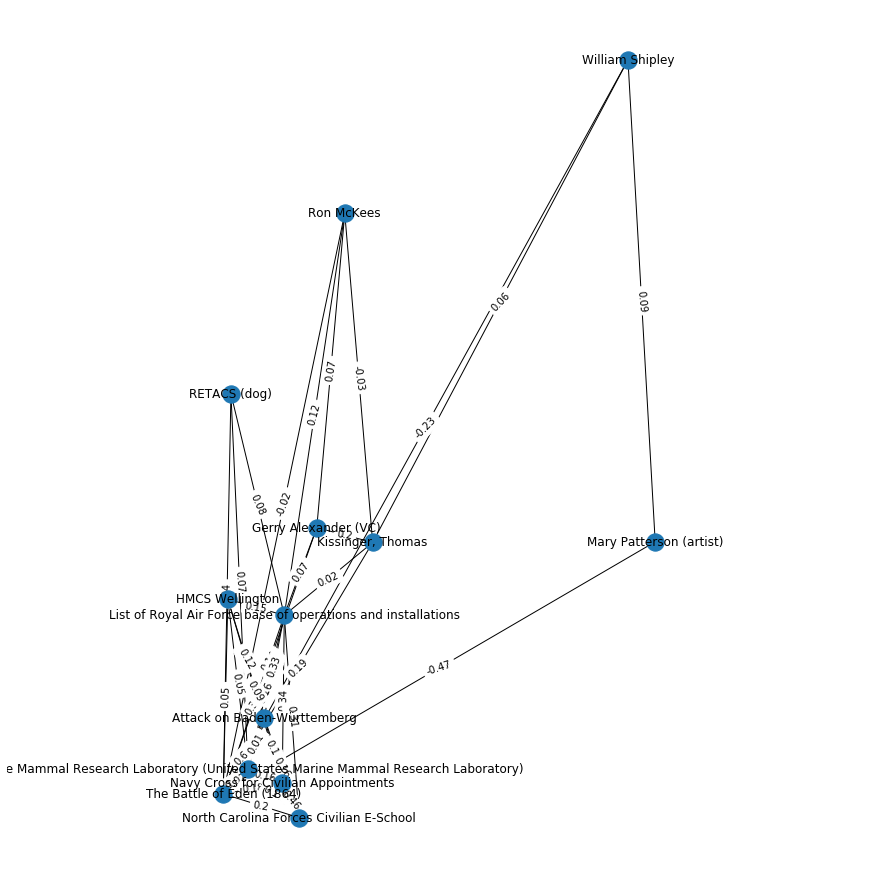

In [21]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.5 # stops labels going off the sides so much
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

## View all generated articles

Note:
- References, External links and Citations sections are frequently empty due to the Wikipedia API not usually picking these up. A different API call is needed to get these. This wasn't known at the time data was collected.
- 'List of ________' articles often have empty sections, this is because the Wikipedia API doesn't return data in tables (and lists are often in tables). Therefore the training data had many empty sections in articles with these titles.

In [22]:
print('\n\n\n'.join(articles))

Gerry Alexander (VC)


Gerry Alexander VC (11 November 1916 – 4 November 2001) was an English recipient of the Victoria Cross, the highest and most prestigious award for gallantry in the face of the enemy that can be awarded to British and Commonwealth forces.


== Details ==

Gerry Alexander was 32 years old, and a sergeant in the 3rd Battalion, The Lancers, British Army during the Second Boer War when the following deed took place for which he was awarded the VC. 
On 15 March 1900 at Bolzano, South Africa, Sergeant Alexander, along with Sergeant Jerome E. Davies and Sergeant Edward Hamblin, performed a gallant and efficient work which enabled a squadron of the Lancers to attack an entrenched Boer baying enemy force and to capture a strong position.
Sergeant Alexander was mortally wounded during the attack and after subsisting for a considerable time he died aged twenty five years and five months at the age of seventy-five.


== Further information ==
Gerry Alexander's father, John Al